# Data preprocessing & extraction

This part does the following:
- Splitting data
- imputate numerical data & encode categorical data
- generate data overview figures
- scaling

In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   dataID                                             4690 non-null   int64  
 1   paper_number                                       4690 non-null   object 
 2   Carbon source 1 (category)                         4690 non-null   float64
 3   Carbon source 1 (g/L)                              4681 non-null   float64
 4   Carbon source 1 heat of combustion (kJ/mol)        4690 non-null   float64
 5   Carbon source 1 heat of combustion (kJ/g)          4690 non-null   float64
 6   Carbon source 2 (category)                         3385 non-null   float64
 7   Carbon source 2 (g/L)                              3385 non-null   float64
 8   Carbon source 2 heat of combustion (kJ/mol)        3385 non-null   float64
 9   Carbon s

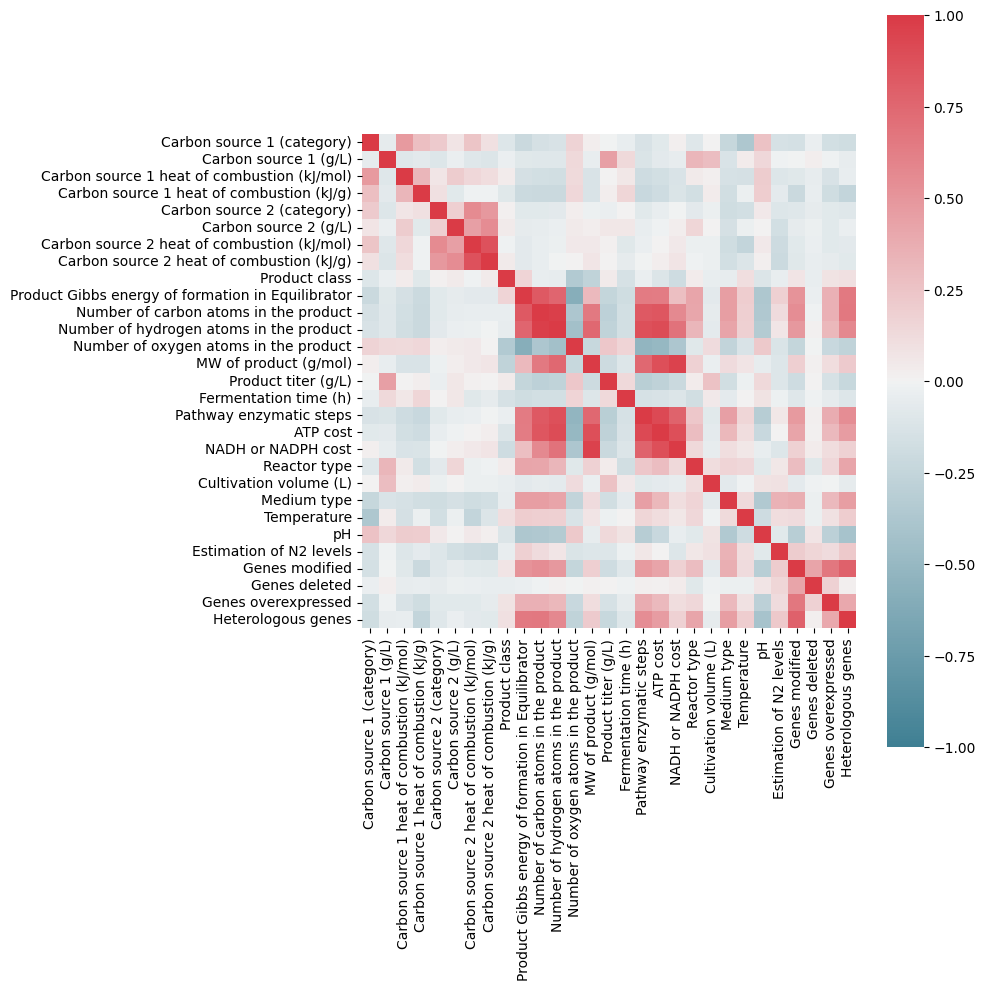

In [9]:
target = 'Product titer (g/L)'
species = 'YL'
if_scale = True

df = pd.read_excel(f"../data/{species}_raw.xlsx", header=1)
print(df.info())

# Count the semicolons in 'genes_modified_updated'
df['Genes modified'] = df['Genes modified'].fillna('').apply(lambda x: x.count(';'))

# Count the ones in 'gene_overexpression' and 'heterologous_gene'
df['Genes overexpressed'] = df['Genes overexpressed'].fillna('').apply(lambda x: str(x).count('1'))
df['Heterologous genes'] = df['Heterologous genes'].fillna('').apply(lambda x: str(x).count('1'))
df['Genes deleted'] = df['Genes deleted'].fillna('').apply(lambda x: str(x).count('1'))

df = df.drop(['dataID', 'paper_number','product_name'], axis=1)

# Impute all NaN data as zero
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# extract product class for plotting
product_class = df_imputed['Product class']
product_class.to_csv(f"../data/{species}_product_class.csv")

# correlation plot
f, ax = plt.subplots()

plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True

corr = df_imputed.corr()
corr_matrix = sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
corr_matrix.figure.savefig(f"../figures/{species}_corr.png", dpi=200)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=6*6)

# scaling
if if_scale:
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)
    X = df_scaled.drop(target, axis=1)
    y = df_scaled[target]
    X_plot = X
    X_plot['plot'] = df_imputed['Product class']
    for train_index, test_index in split.split(X_plot, product_class):
        X_train, X_test = X_plot.iloc[train_index], X_plot.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
else:
    X = df_imputed.drop(target, axis=1)
    y = df_imputed[target]
    for train_index, test_index in split.split(X, product_class):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# to csv
if if_scale:
    X_train.to_csv(f"../data/{species}_xtrain_scaled.csv")
    X_test.to_csv(f"../data/{species}_xtest_scaled.csv")
    y_train.to_csv(f"../data/{species}_ytrain_scaled.csv")
    y_test.to_csv(f"../data/{species}_ytest_scaled.csv")
else:
    X_train.to_csv(f"../data/{species}_xtrain.csv")
    X_test.to_csv(f"../data/{species}_xtest.csv")
    y_train.to_csv(f"../data/{species}_ytrain.csv")
    y_test.to_csv(f"../data/{species}_ytest.csv")